In [132]:
import numpy as np

from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

import pandas as pd

In [15]:
#load dataframe from csv
demographics_data = pd.read_csv("data/zip/2018_demographic_data_edited.csv", delimiter=',')
print(demographics_data.shape)
del demographics_data["Geo_ZCTA5"]
del demographics_data["Geo_ZCTA3"]
del demographics_data["Geo_LOGRECNO"]
del demographics_data["Geo_GEOCOMP"]
del demographics_data["Geo_SUMLEV"]
print(demographics_data.shape)

(33120, 2151)
(33120, 2146)


In [17]:
null_counts = demographics_data.isnull().sum()
print(null_counts[null_counts > 0])

SE_A01004_001      564
SE_A01004_002      843
SE_A01004_003      897
SE_A10003_001      726
SE_A10003B_001    2496
                  ... 
SE_A13007_009       35
SE_A13007_010       35
SE_A13007_011       35
SE_A10064_001       35
SE_A10064_002       35
Length: 870, dtype: int64


In [109]:
#reduced_demos = demographics_data[["SE_A00002_002", "SE_A10003_001", "SE_B12001_002", "SE_B12001_003", "SE_B12001_004", "SE_A14002_002", "SE_A14002_003", "SE_A14002_004", "SE_A14002_005", "SE_A14002_006", "SE_A14002_007", "SE_A14002_008", "SE_A14002_009", "SE_A14002_010", "SE_A14002_011", "SE_A14002_012", "SE_A14028_001", "SE_A10035B_002", "SE_A10035B_003", "SE_A10035B_004", "SE_A10035B_005", "SE_A10035B_006", "SE_A10035B_007", "SE_A10035B_008", "SE_A10035B_009" ]]
reduced_demos = demographics_data[["SE_A00002_002", "SE_A14028_001", "SE_A14008_001"]]

In [110]:
null_counts = reduced_demos.isnull().sum()
print(null_counts[null_counts > 0])

SE_A14028_001     948
SE_A14008_001    1220
dtype: int64


In [111]:
reduced_demos = reduced_demos.dropna()
print(reduced_demos.shape)

(31900, 3)


In [95]:
#reduced_demos = StandardScaler().fit_transform(reduced_demos)

In [112]:
reduced_demos[0:5]

,SE_A00002_002,SE_A14028_001,SE_A14008_001
0,267.9506,0.5238,18893.29346
1,1255.4210,0.5034,25019.06893
2,1543.9250,0.5666,28089.33084
3,152.1423,0.4818,16419.41410
4,753.8562,0.4689,26909.25717


 FOR EPS :  0.5  AND SAMPLES  5
Estimated number of clusters: 0
Estimated number of noise points: 31900


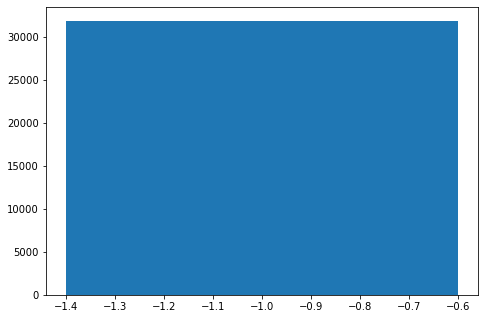

 FOR EPS :  1.0  AND SAMPLES  5
Estimated number of clusters: 0
Estimated number of noise points: 31900


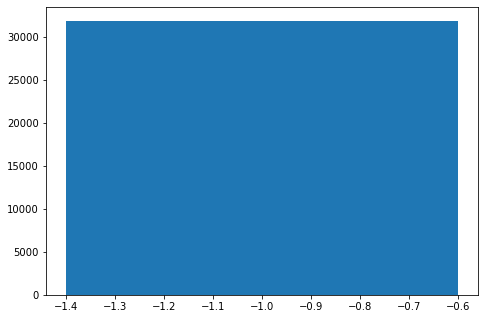

 FOR EPS :  10.0  AND SAMPLES  5
Estimated number of clusters: 387
Estimated number of noise points: 29265


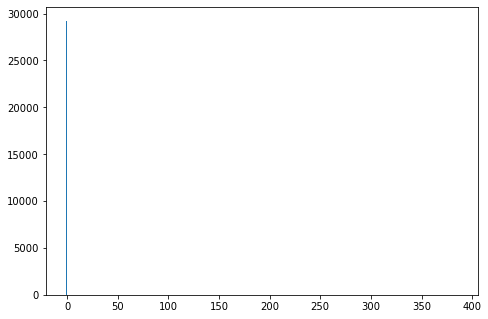

 FOR EPS :  100.0  AND SAMPLES  5
Estimated number of clusters: 143
Estimated number of noise points: 10334


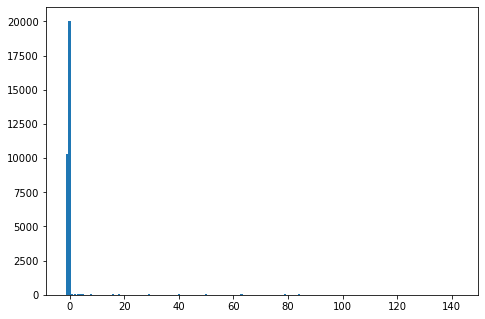

 FOR EPS :  500.0  AND SAMPLES  5
Estimated number of clusters: 84
Estimated number of noise points: 2276


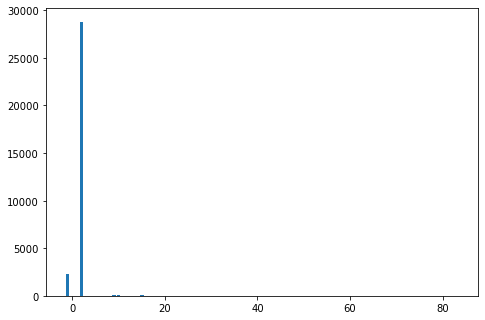

 FOR EPS :  1000.0  AND SAMPLES  5
Estimated number of clusters: 33
Estimated number of noise points: 1033


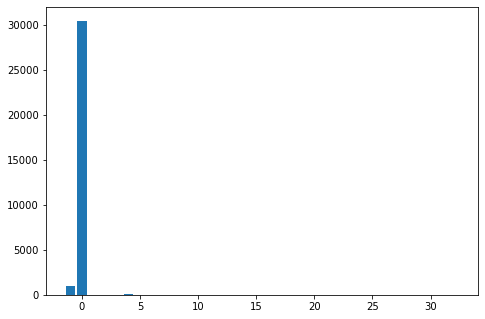

 FOR EPS :  0.5  AND SAMPLES  10
Estimated number of clusters: 0
Estimated number of noise points: 31900


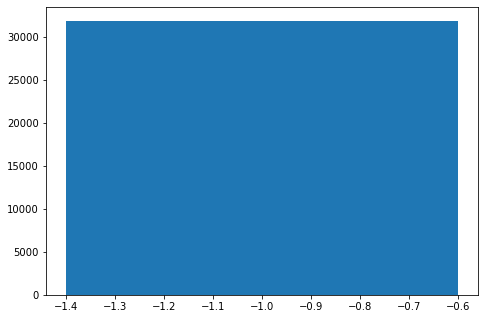

 FOR EPS :  1.0  AND SAMPLES  10
Estimated number of clusters: 0
Estimated number of noise points: 31900


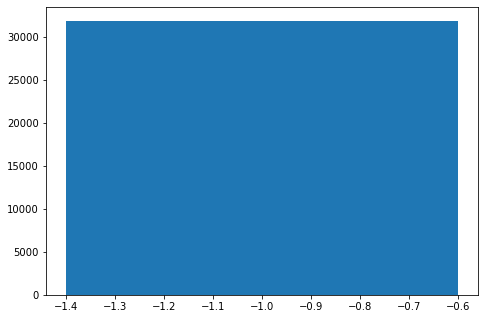

 FOR EPS :  10.0  AND SAMPLES  10
Estimated number of clusters: 1
Estimated number of noise points: 31887


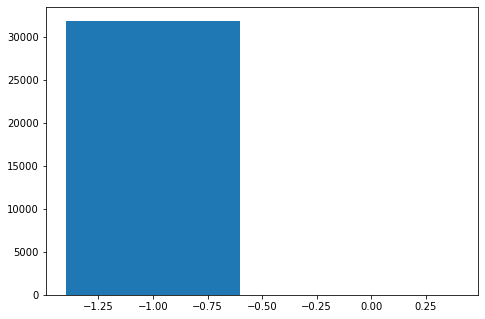

 FOR EPS :  100.0  AND SAMPLES  10
Estimated number of clusters: 35
Estimated number of noise points: 12352


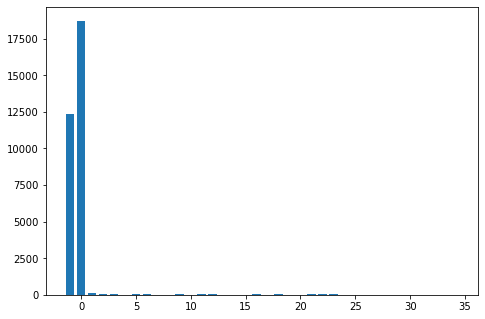

 FOR EPS :  500.0  AND SAMPLES  10
Estimated number of clusters: 46
Estimated number of noise points: 3914


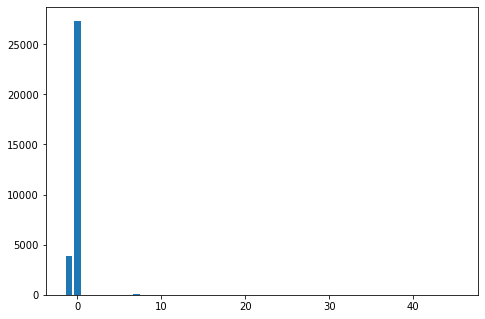

 FOR EPS :  1000.0  AND SAMPLES  10
Estimated number of clusters: 10
Estimated number of noise points: 1617


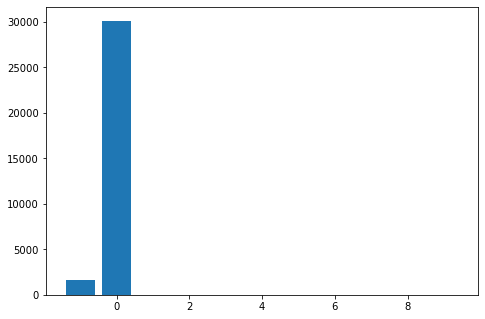

 FOR EPS :  0.5  AND SAMPLES  50
Estimated number of clusters: 0
Estimated number of noise points: 31900


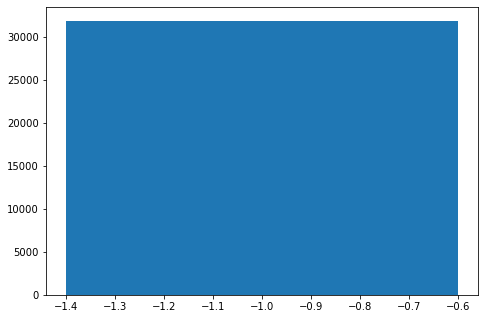

 FOR EPS :  1.0  AND SAMPLES  50
Estimated number of clusters: 0
Estimated number of noise points: 31900


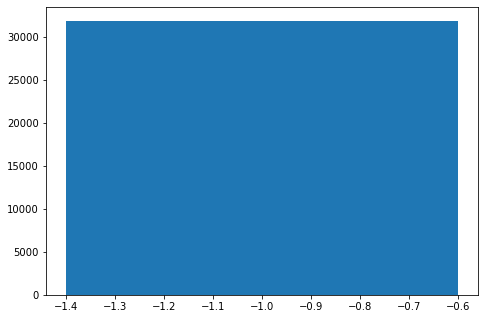

 FOR EPS :  10.0  AND SAMPLES  50
Estimated number of clusters: 0
Estimated number of noise points: 31900


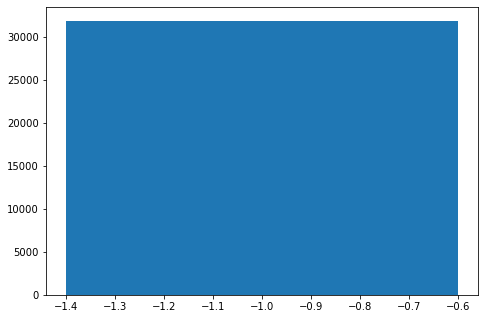

 FOR EPS :  100.0  AND SAMPLES  50
Estimated number of clusters: 16
Estimated number of noise points: 18090


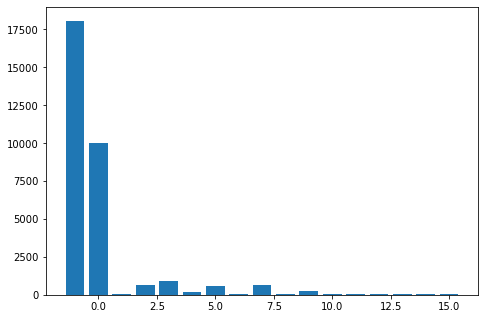

 FOR EPS :  500.0  AND SAMPLES  50
Estimated number of clusters: 5
Estimated number of noise points: 8527


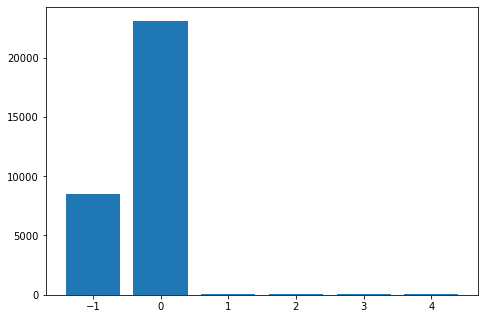

 FOR EPS :  1000.0  AND SAMPLES  50
Estimated number of clusters: 3
Estimated number of noise points: 4601


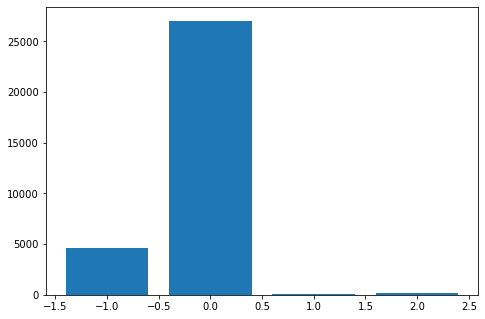

 FOR EPS :  0.5  AND SAMPLES  100
Estimated number of clusters: 0
Estimated number of noise points: 31900


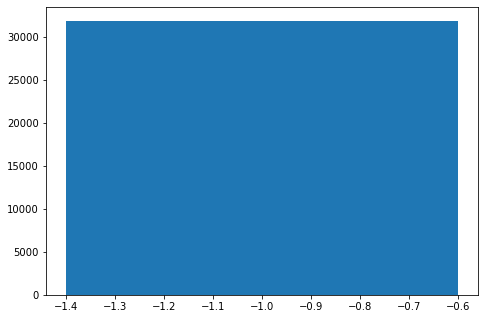

 FOR EPS :  1.0  AND SAMPLES  100
Estimated number of clusters: 0
Estimated number of noise points: 31900


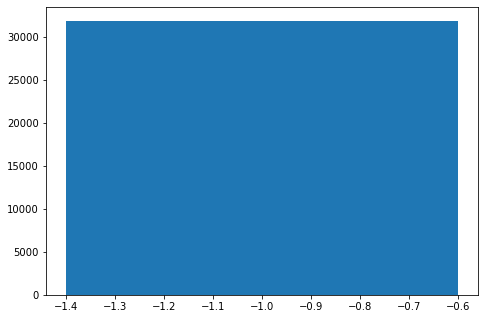

 FOR EPS :  10.0  AND SAMPLES  100
Estimated number of clusters: 0
Estimated number of noise points: 31900


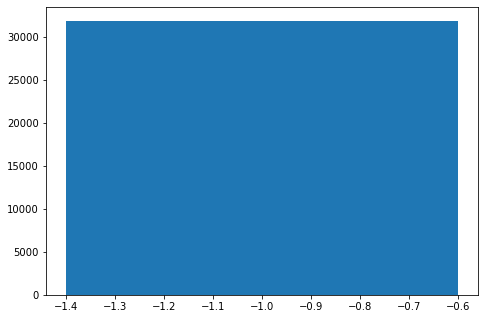

 FOR EPS :  100.0  AND SAMPLES  100
Estimated number of clusters: 19
Estimated number of noise points: 29168


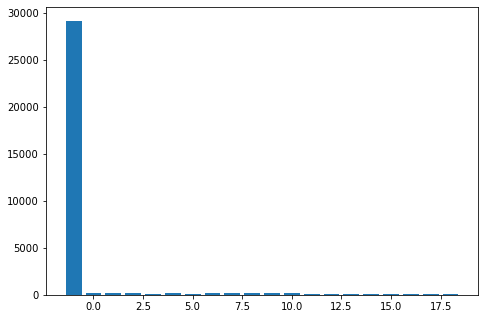

 FOR EPS :  500.0  AND SAMPLES  100
Estimated number of clusters: 3
Estimated number of noise points: 10203


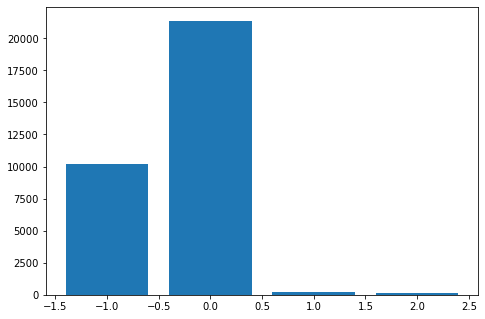

 FOR EPS :  1000.0  AND SAMPLES  100
Estimated number of clusters: 3
Estimated number of noise points: 6561


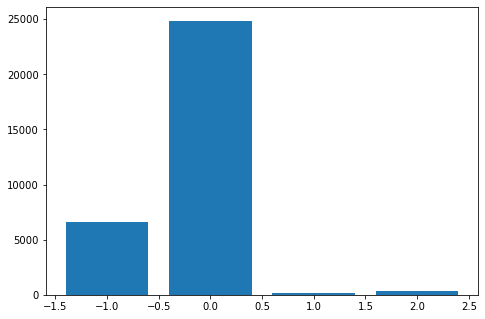

 FOR EPS :  0.5  AND SAMPLES  250
Estimated number of clusters: 0
Estimated number of noise points: 31900


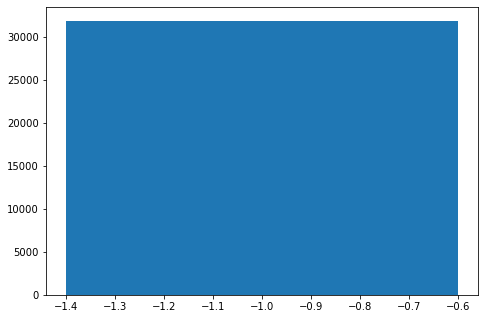

 FOR EPS :  1.0  AND SAMPLES  250
Estimated number of clusters: 0
Estimated number of noise points: 31900


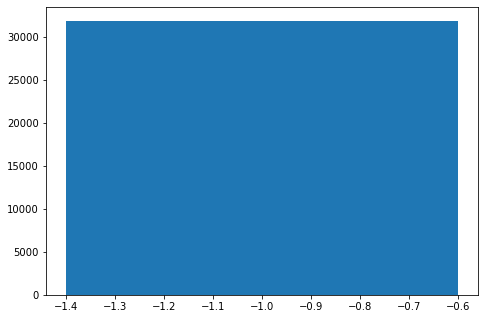

 FOR EPS :  10.0  AND SAMPLES  250
Estimated number of clusters: 0
Estimated number of noise points: 31900


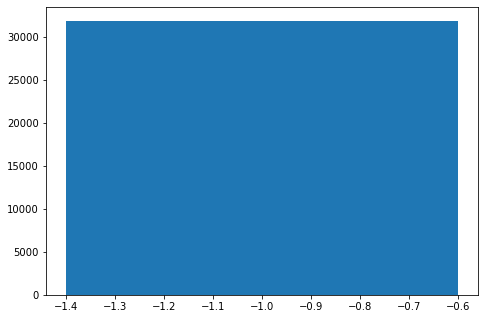

 FOR EPS :  100.0  AND SAMPLES  250
Estimated number of clusters: 0
Estimated number of noise points: 31900


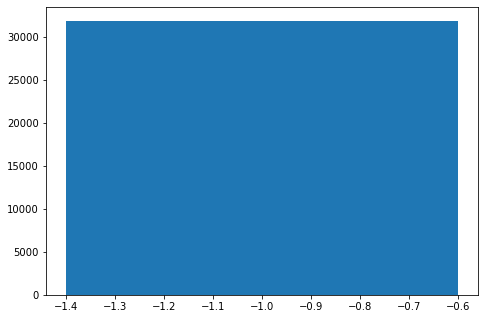

 FOR EPS :  500.0  AND SAMPLES  250
Estimated number of clusters: 1
Estimated number of noise points: 14325


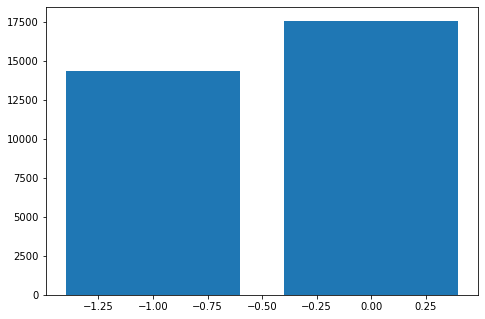

 FOR EPS :  1000.0  AND SAMPLES  250
Estimated number of clusters: 1
Estimated number of noise points: 9405


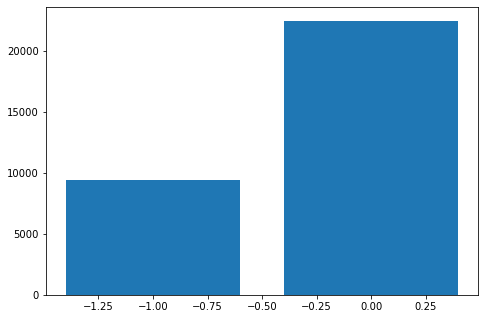

 FOR EPS :  0.5  AND SAMPLES  500
Estimated number of clusters: 0
Estimated number of noise points: 31900


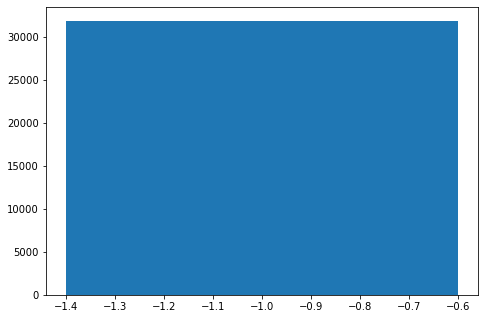

 FOR EPS :  1.0  AND SAMPLES  500
Estimated number of clusters: 0
Estimated number of noise points: 31900


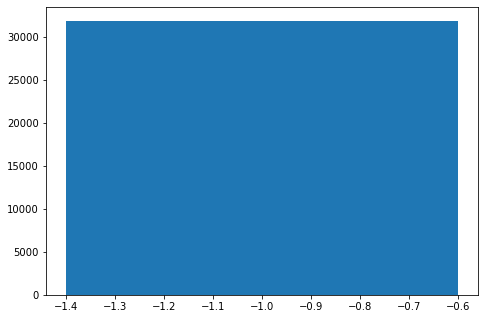

 FOR EPS :  10.0  AND SAMPLES  500
Estimated number of clusters: 0
Estimated number of noise points: 31900


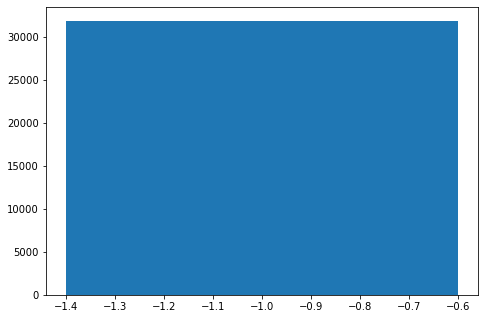

 FOR EPS :  100.0  AND SAMPLES  500
Estimated number of clusters: 0
Estimated number of noise points: 31900


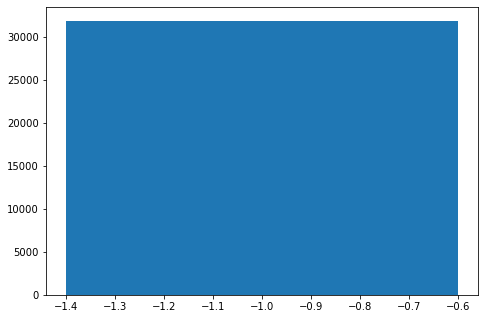

 FOR EPS :  500.0  AND SAMPLES  500
Estimated number of clusters: 3
Estimated number of noise points: 22958


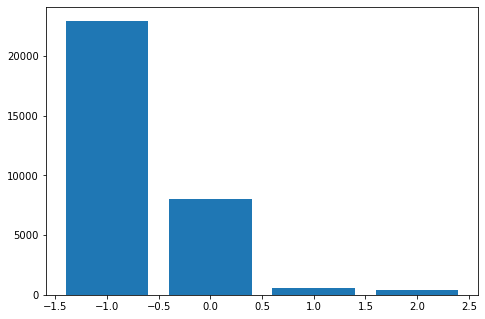

 FOR EPS :  1000.0  AND SAMPLES  500
Estimated number of clusters: 1
Estimated number of noise points: 12975


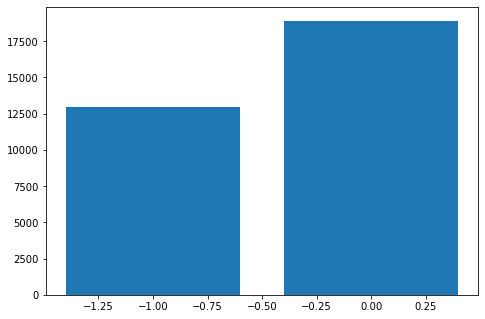

In [160]:
eps = [0.5, 1.0, 10.0, 100.0, 500.0, 1000.0]
samples = [5, 10, 50, 100, 250, 500]

for s in samples:
    for e in eps:
        # define the model
        dbscan_model = DBSCAN(eps=e, min_samples=s)

        # train the model
        dbscan_model.fit(reduced_demos)

        core_samples_mask = np.zeros_like(dbscan_model.labels_, dtype=bool)
        core_samples_mask[dbscan_model.core_sample_indices_] = True
        labels = dbscan_model.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        print(" FOR EPS : ", e, " AND SAMPLES ", s)
        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)

        # unique_labels = set(labels)
        # for k in unique_labels:
        #     class_member_mask = (labels == k)
        #     xy = reduced_demos[class_member_mask & core_samples_mask]
        #     print("number of members in cluster ", k, ": ", len(xy))
        #     print(xy.head())


        clusters = np.unique(labels, return_counts=True)

        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.bar(clusters[0],clusters[1])
        plt.show()